(supervised:ann:performance)=
# Improving CNN performance

So far we only considered the basics of CNNs. Now we discuss techniques for improving prediction quality and for decreasing training times. First we introduce the ideas, then we implement all techniques for better cats and dogs classification.

## Data Augmentation

Prediction accuracy heavily depends on amount and variety of data available for training. Collecting more data is expensive. Thus, we could generate synthetic data from existing data. In case of image data we may rotate, scale, translate or distort the images to get new images showing identical objects in slightly different ways. This idea is known as *data augmentation* and increases the amount of data as well as the variety.

Kera provides several types of data augmentation (rotation, zoom, pan, brightness, flip, and some more). Activating this feature yields a stream of augmented images. Augmentation steps have to be incorporated to the model via preprocessing layers, see [Image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

## Pre-trained CNNs

CNNs have two major components: the feature extraction stack (convolutional and pooling layers) and the decision stack (dense layers for classification or regression). The task of the feature extraction stack is to automatically preprocess images resulting in a set of feature maps containing higher level information than just colored pixels. Based on this higher level information the decision stack predicts the targets.

With this two-step approach in mind we may use more powerful feature extraction. The feature extraction part is more or less the same for all object classification problems in image processing. Thus, we might use a feature extraction stack trained on much larger training data and with much more computational resources. Such pre-trained CNNs are available in the internet and Keras ships with some, too. See [Keras Applications](https://keras.io/api/applications/) for a list of pre-trained CNNs in Keras.

In Keras' documentation the feature extraction stack is called *convolutional base* and the decision stack is the *head* of the CNN. When loading a pre-trained model we have to decide wether to load the full model or only the convolutional base. If we do not use the pre-trained head, we have to specify the input shape for the network. This sounds a bit strange, but the convolutional base works for arbitrary input shapes and specifing a concrete shape fixes the output shape of the convolutional base. If we use the pre-trained head, then the output shape of the convolutional base has to fit the input shape of the head. Thus, the head determines the input shape of the CNN.

## Other Minimization Algorithms

Up to now we only considered simple gradient descent. But there are much better algorithms for minimizing loss functions. Keras implements some of them and we should use them although at the moment we do not know what those algorithms do in detail. Advanced minimization techniques are not covered in this book.

## Faster Preprocessing

Loading images from the disk and preprocessing them during training might slow down training. One solution is to load all images (including augmentation) to memory before training, but large memory is required. Another solution is to asynchronously load and preprocess data. That is, while the GPU does some calculations the CPU loads and preprocesses images. Keras and TensorFlow support such advanced techniques, but we will not cover them here.

## Example

We consider object detection with cats and dogs again.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow.keras as keras

data_path = '/home/jef19jdw/myfiles/datasets_teaching/ds2/catsdogs/data/'

2023-05-08 07:12:32.560037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To speed up training we would like to have all data in memory. Images have $128^2=16384$ pixels, each taking 3 bytes for the colors (one byte per channel) if color values are integers. For colors scaled to $[0,1]$ we need 4 bytes per channel with `np.float32` as data type. Thus, we need 196608 bytes per image, say 200 kB. These are 5 images per MB or 5000 images per GB. Our data set has 25000 images and we could increase it to arbitrary size by data augmentation. Note that data augmentation is only useful for training data. Validation and test data should not be augmented. To save memory we do augmentation in real-time, that is, we only keep original training images in memory and generate batches of augmented images as needed.

To load all images we use Keras' methods for loading images from directories and inferring labels. Then we extract images and labels from the resulting data structure to ensure they are in memory (TensorFlow `Dataset` objects do not necessarily read all data to memory).

In [3]:
img_size = 128

train_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/train',
    label_mode = 'categorical',    # one-hot encoding with two columns
    batch_size=15000,    # load all images in one batch
    image_size=(img_size, img_size),
    validation_split=0.25,
    subset='training',
    seed=0
)
val_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/train',
    label_mode = 'categorical',
    batch_size=5000,
    image_size=(img_size, img_size),
    validation_split=0.25,
    subset='validation',
    seed=0    # same seed as for training
)
test_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/test',
    label_mode = 'categorical',
    batch_size=5000,
    image_size=(img_size, img_size),
)

# extract images and labels from TensorFlow Dataset
train_images, train_labels = next(iter(train_data))
val_images, val_labels = next(iter(val_data))
test_images, test_labels = next(iter(test_data))

Found 20000 files belonging to 2 classes.
Using 15000 files for training.


2023-05-08 07:12:34.818592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-08 07:12:34.818623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: WHZ-46349
2023-05-08 07:12:34.818631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: WHZ-46349
2023-05-08 07:12:34.818725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-05-08 07:12:34.818746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-05-08 07:12:34.818752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-05-08 07:12:34.818982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Networ

Found 20000 files belonging to 2 classes.
Using 5000 files for validation.
Found 5000 files belonging to 2 classes.


2023-05-08 07:12:45.792236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14408 of 120000
2023-05-08 07:12:46.293722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-08 07:12:46.304312: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2949120000 exceeds 10% of free system memory.
2023-05-08 07:12:51.302941: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 983040000 exceeds 10% of free system memory.
2023-05-08 07:12:56.156447: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 983040000 exceeds 10% of free system memory.


Now we start to build the model. As mentioned above, data augmentation has to be implemented via preprocessing layers in the model.

```{important}
Due to a bug in TensorFlow 2.9 and above training of Keras models with preprocessing layers is extremely slow. See [TensorFlow issue](https://github.com/tensorflow/tensorflow/issues/55639) for current discussion.
```

In [4]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(img_size, img_size, 3)))

#model.add(keras.layers.RandomFlip())
#model.add(keras.layers.RandomRotation(0.5))
#model.add(keras.layers.RandomZoom(0.2))
#model.add(keras.layers.RandomContrast(0.2))
#model.add(keras.layers.RandomBrightness(0.2, value_range=(0, 1)))

Note that preprocessing layers in Keras only are active during training. In evaluation and prediction phases they are skipped.

Next, we load a pre-trained convolutional base.

In [5]:
conv_base = keras.applications.Xception(
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

We see that there are new layer types: separable convolutions and batch normalization. Separable convolutions are a special case of usual convolution allowing for more efficient computation by restricting to specially structured filters. Batch normalization is a kind of rescaling layer outputs. The more important observation is the output shape: 4x4x2048. That is, we obtain 2048 feature maps each of size 4x4. This is where we connect our decision stack.

Models in Keras behave like layers (the `Model` class inherits from `Layer`). Thus, we may add the pre-trained convolutional base as layer to our model.

When using pre-trained models, data preprocessing has to be done in exactly the same way as has been done in training. For each pre-trained model in Keras there is a [`preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/preprocess_input) function doing necessary preprocessing. To apply this function to all data flowing through our model we use a [Lambda layer](https://keras.io/api/layers/core_layers/lambda/).

In [6]:
model.add(keras.layers.Lambda(keras.applications.xception.preprocess_input))
model.add(conv_base)

To complete the model we add dense layers.

In [7]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='relu', name='dense1'))
model.add(keras.layers.Dense(10, activation='relu', name='dense2'))
model.add(keras.layers.Dense(2, activation='sigmoid', name='out'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense1 (Dense)              (None, 10)                327690    
                                                                 
 dense2 (Dense)              (None, 10)                110       
                                                                 
 out (Dense)                 (None, 2)                 22        
                                                                 
Total params: 21,189,302
Trainable params: 21,134,774
No

Before we start training we have to tell Keras to keep the weights of the convolutional base constant. We simply have to set the layer's `trainable` attribute to `False`:

In [8]:
model.get_layer('xception').trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense1 (Dense)              (None, 10)                327690    
                                                                 
 dense2 (Dense)              (None, 10)                110       
                                                                 
 out (Dense)                 (None, 2)                 22        
                                                                 
Total params: 21,189,302
Trainable params: 327,822
Non-t

In [9]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now training can be started.

In [10]:
loss = []
val_loss = []
acc = []
val_acc = []

In [11]:
history = model.fit(
    train_images, train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    batch_size=100
)

loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['categorical_accuracy'])
val_acc.extend(history.history['val_categorical_accuracy'])

Epoch 1/5
150/150 [==============================] - 594s 4s/step - loss: 0.2113 - categorical_accuracy: 0.9325 - val_loss: 0.1298 - val_categorical_accuracy: 0.9496
Epoch 2/5
150/150 [==============================] - 577s 4s/step - loss: 0.1285 - categorical_accuracy: 0.9529 - val_loss: 0.1015 - val_categorical_accuracy: 0.9592
Epoch 3/5
150/150 [==============================] - 571s 4s/step - loss: 0.1036 - categorical_accuracy: 0.9629 - val_loss: 0.1071 - val_categorical_accuracy: 0.9580
Epoch 4/5
150/150 [==============================] - 587s 4s/step - loss: 0.0906 - categorical_accuracy: 0.9661 - val_loss: 0.1296 - val_categorical_accuracy: 0.9604
Epoch 5/5
150/150 [==============================] - 556s 4s/step - loss: 0.0838 - categorical_accuracy: 0.9673 - val_loss: 0.1161 - val_categorical_accuracy: 0.9592


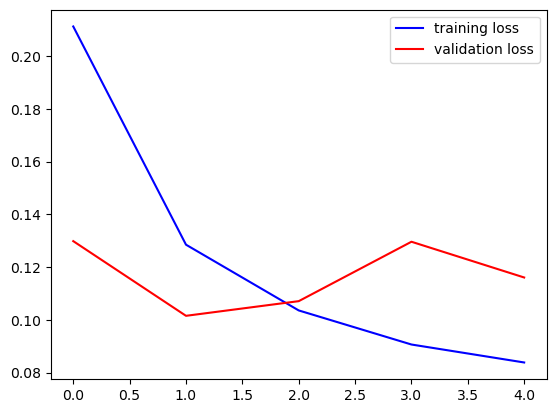

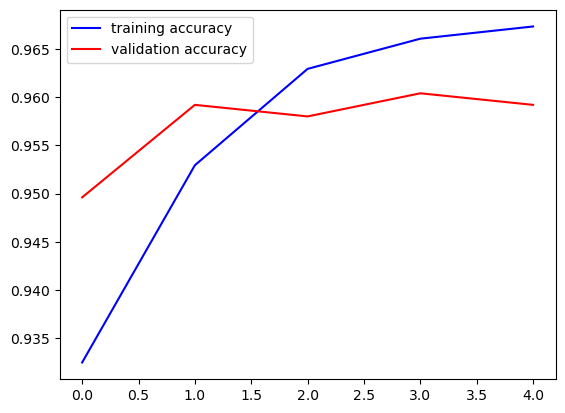

In [12]:
fig, ax = plt.subplots()
ax.plot(loss, '-b', label='training loss')
ax.plot(val_loss, '-r', label='validation loss')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(acc, '-b', label='training accuracy')
ax.plot(val_acc, '-r', label='validation accuracy')
ax.legend()
plt.show()

In [13]:
model.save('cnnmodelimproved.keras')

INFO:tensorflow:Assets written to: cnnmodelimproved/assets


INFO:tensorflow:Assets written to: cnnmodelimproved/assets


In [14]:
test_loss, test_metric = model.evaluate(x=test_images, y=test_labels)
print(test_metric)

157/157 [==============================] - 136s 860ms/step - loss: 0.1460 - categorical_accuracy: 0.9516
0.9516000151634216
